<a href="https://colab.research.google.com/github/Yutong-Lu/CHL5230FinalProject/blob/main/Yutong-NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch as t
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

In [2]:
data = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
data.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
0,65,126.0,2013-06-11,31.000000,2013-06-11,1.66,2013-06-14,1.11,2013-06-14,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000255903,NaT,NaT,No
1,62,135.0,2014-06-19,25.846483,2014-10-17,2.49,2014-05-28,1.37,2014-05-28,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000256456,NaT,NaT,No
2,63,133.0,2012-07-31,30.900000,2011-12-01,1.65,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1001000000000054,NaT,NaT,No
3,51,136.0,2014-01-06,56.710775,2014-01-06,2.80,2014-01-14,1.94,2014-01-14,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000259496,NaT,NaT,No
4,40,123.0,2015-06-12,33.067867,2015-06-12,2.48,2015-06-24,1.17,2015-06-24,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000262094,NaT,NaT,No


In [3]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

# Create indicator for using hypertension meds/corticosteroid
data['Use_of_Hypertension_Medications'] = data['Hypertension_Medications'].notnull().astype('int')
data['Use_of_Corticosteroids'] = data['Corticosteroids'].notnull().astype('int')

# Create a subset with no date
df = data[['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

numerical_columns = ['Age_at_Exam', 'sBP', 'BMI', 'A1c', 'TG', 'FBS', 'Total_Cholesterol']

In [4]:
# define features and outcome
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

# split training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)

# Normalizing data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7000, 14), (1500, 14), (1500, 14), (7000, 1), (1500, 1), (1500, 1))

In [5]:
# Imputation
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_filled_mice = imputer.fit_transform(X_train)
X_val_filled_mice = imputer.transform(X_val)
X_test_filled_mice = imputer.transform(X_test)

First NN with 2 layers

In [10]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((14, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

In [11]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

In [21]:
# Convert the training data to PyTorch tensors
X = t.Tensor(X_train_filled_mice).type(t.float32)
Y = t.Tensor(y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y.view(-1))

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Text(0, 0.5, 'loss')

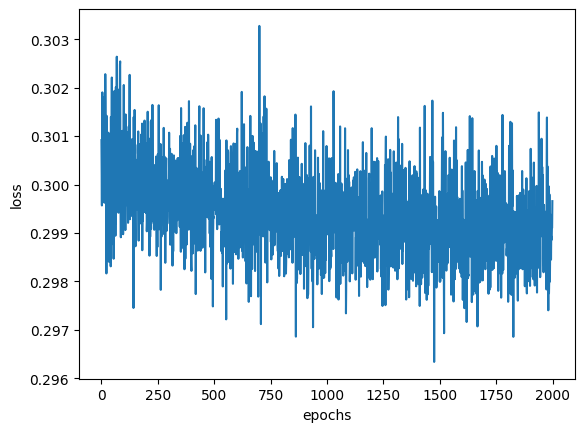

In [22]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

In [27]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test_filled_mice).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y.view(-1))  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train_filled_mice).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y.view(-1))  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

0.3548193871974945
0.2949311435222626


Regularization using drop-out

In [28]:
number_of_input_features = 14  # Number of input features in the dataset

# Reduced number of hidden units to 5 and just using 1 hidden layer
number_of_hidden_units = 5  # Number of hidden units in the neural network
epochs = 1000  # Number of training epochs
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 32  # Number of samples in each training batch
dropout_probablity = 0.6  # Probability of dropping out a neuron in dropout layer

# Convert training and testing data to PyTorch tensors
X_train_tensor = t.Tensor(X_train_filled_mice).type(t.float32)
Y_train_tensor = t.Tensor(y_train).type(t.float32)
X_test_tensor = t.Tensor(X_val_filled_mice).type(t.float32)
Y_test_tensor = t.Tensor(y_val).type(t.float32)

# Create a training dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    Tanh(),  # Add Tanh activation function
    Dropout(dropout_probablity),  # Dropout layer to prevent overfitting
    Linear(number_of_hidden_units, 1),  # Another linear layer
    Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
validation_accuracy_list = []  # List to store validation accuracy

# Training loop
for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1).unsqueeze(1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy: {train_accuracy}, validation_accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

epoch 0/1000 ---> train_accuracy: 0.5007697939872742, validation_accuracy: 0.5005724430084229
epoch 1/1000 ---> train_accuracy: 0.499666690826416, validation_accuracy: 0.499509334564209
epoch 2/1000 ---> train_accuracy: 0.4994836747646332, validation_accuracy: 0.4992640018463135
epoch 3/1000 ---> train_accuracy: 0.4995681643486023, validation_accuracy: 0.4996933341026306
epoch 4/1000 ---> train_accuracy: 0.4996808171272278, validation_accuracy: 0.4997955560684204
epoch 5/1000 ---> train_accuracy: 0.49981698393821716, validation_accuracy: 0.4999386668205261
epoch 6/1000 ---> train_accuracy: 0.499957799911499, validation_accuracy: 0.5002248883247375
epoch 7/1000 ---> train_accuracy: 0.4996808171272278, validation_accuracy: 0.4997137784957886
epoch 8/1000 ---> train_accuracy: 0.49977004528045654, validation_accuracy: 0.49991822242736816


KeyboardInterrupt: ignored

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()